# Load Data
Load up the word vector and raw FDA approved drug names.

In [1]:
import numpy as np
from gensim.models import KeyedVectors
# load the word embedding model
wv = KeyedVectors.load_word2vec_format('bio_embedding_intrinsic', binary=True)
# and our approved drug names
drugs = None
with open('fda_approved/fda_approved.processed.names') as infile:
    drugs = [l.strip() for l in infile]

# Convert Raw FDA Approved Drug Names to Vectors
Here we take the FDA approved drug names and convert them to word vectors.
First, we break them into tokens.
Then, for each drug, we get word vectors for each individual token and average them for the drug.
We drop individual tokens that are not in the vocab, modifying the drug name along with the average.
Obviously, drug names with no tokens in the vocab are dropped.

In [2]:
# we're first going to convert every multi-token drug into a word vector average
def wv_avg_tokens(tokens, wv):
    # collect the unit vectors for each token
    new_toks = list()
    unit_vecs = list()
    for t in tokens:
        # skip tokens that aren't in the embedding
        if t in wv:
            # keep the token
            new_toks.append(t)
            # scale to a unit vector
            uvec = wv[t]
            uvec = uvec / np.linalg.norm(uvec)
            unit_vecs.append(uvec)
    # now add them up if we got at least one
    if len(unit_vecs) < 1:
        return None,None
    # sum
    ret_vec = unit_vecs[0]
    for uvec in unit_vecs[1:]:
        ret_vec = ret_vec + uvec
    # and rescale
    ret_vec = ret_vec / np.linalg.norm(ret_vec)
    return new_toks,ret_vec

In [3]:
# how many raw drugs are we starting with again?
print('Starting drug count: {0}'.format(len(drugs)))
# gather up our drug vectors with the corresponding "new" names (based on token dropping)
drug_vec_tups = list()
# and track the drugs that were dropped completely
dropped_drugs = list()
for d in drugs:
    # split and average word vectors
    toks = d.split()
    new_toks,drug_vec = wv_avg_tokens(toks, wv)
    # check for complete loss of a drug, or track the new name and vector
    if drug_vec is None:
        dropped_drugs.append(d)
    else:
        new_name = ' '.join(new_toks)
        drug_vec_tups.append((new_name, drug_vec))
# and how many raw drug names were we able to convert into something
print('Converted drug count: {0}'.format(len(drug_vec_tups)))
# because we have modified drug names, we may have ended up with new dupes
tmp = list()
drug_seen = set()
for dvt in drug_vec_tups:
    # also handle effective equivalents from combinations (e.g. 'A and B' vs 'B and A')
    # just sort the tokens first
    comp_name = ' '.join(sorted(dvt[0].split()))
    if comp_name not in drug_seen:
        tmp.append(dvt)
        drug_seen.add(comp_name)
drug_vec_tups = tmp
# and how many distinct converted drug names do we have
print('Final distinct drug vector count: {0}'.format(len(drug_vec_tups)))

Starting drug count: 8561
Converted drug count: 6506
Final distinct drug vector count: 5833


# Build Treatment Analogy Vectors
Now we generate treatment analogy vectors.
We use three analogies: Metformin-Diabetes, Benazepril-Hypertension, and Albuterol-Asthma.
These are the vectors we will use to rank the drugs.

In [4]:
def get_treatment_analogy_vector(seed_drug, seed_disease, query_disease, wv):
    drug_v = wv[seed_drug] / np.linalg.norm(wv[seed_drug])
    dis_v = wv[seed_disease] / np.linalg.norm(wv[seed_disease])
    qd_v = wv[query_disease] / np.linalg.norm(wv[query_disease])
    treat_analogy_vec = drug_v - dis_v + qd_v
    treat_analogy_vec = treat_analogy_vec / np.linalg.norm(treat_analogy_vec)
    return treat_analogy_vec

In [5]:
metf_diab_sars_v = get_treatment_analogy_vector('metformin', 'diabetes', 'sars', wv)
benz_hypr_sars_v = get_treatment_analogy_vector('benazepril', 'hypertension', 'sars', wv)
albu_asth_sars_v = get_treatment_analogy_vector('albuterol', 'asthma', 'sars', wv)

# Check Top 20 Hits for Treatment Vectors
We want to manually evaluate the top 20 hits for each treatment analogy to check for drugs and drug targets.
Finding drugs and drug targets in the top hits would suggest that the treatment vectors are in the right neighborhood.

In [6]:
metf_diab_sars_top20 = wv.most_similar(positive=[metf_diab_sars_v], topn=20)
benz_hypr_sars_top20 = wv.most_similar(positive=[benz_hypr_sars_v], topn=20)
albu_asth_sars_top20 = wv.most_similar(positive=[albu_asth_sars_v], topn=20)

### Metformin/Diabetes Top 20

In [7]:
# just have a quick look at the hits and similarities
print('\n'.join([str(h) for h in metf_diab_sars_top20]))

('sars', 0.7350299954414368)
('sars-cov', 0.5995138883590698)
('sars-3cl', 0.5938767194747925)
('sars-3clpro', 0.5917655229568481)
('sars-like', 0.588849663734436)
('sars-covs', 0.5769191980361938)
('sars-cov-induced', 0.5742612481117249)
('sars-cov-mediated', 0.5720081329345703)
('sars-cov-like', 0.5706111192703247)
('anti-sars-cov', 0.5702002048492432)
('pcsars-cov', 0.5684103965759277)
('hsars-cov', 0.5669524073600769)
('sars-co', 0.5651364326477051)
('anticoronaviral', 0.5618479251861572)
('cantharimide', 0.560847818851471)
('sar405', 0.5591368675231934)
('peramivir', 0.5569697022438049)
('norcantharidin-induced', 0.5555315017700195)
('cantharidin-mediated', 0.5551379919052124)
('delaviridine', 0.5549776554107666)


### Benazepril/Hypertension Top 20

In [8]:
# just have a quick look at the hits and similarities
print('\n'.join([str(h) for h in benz_hypr_sars_top20]))

('sars', 0.6842663288116455)
('sars-3cl', 0.6048033237457275)
('sars-3clpro', 0.5865695476531982)
('sars-', 0.5783016681671143)
('sars-cov', 0.5710662007331848)
('sars-covs', 0.5611740350723267)
('p-sars', 0.5571819543838501)
('sars-like', 0.5532997250556946)
('sarsp', 0.550118625164032)
('sars-cov-like', 0.5482956171035767)
('sars-hcov', 0.5416980981826782)
('anti-sars-cov', 0.5390284061431885)
('sars-s', 0.5341991186141968)
('coronavirion', 0.5340977907180786)
('lycodine', 0.5312058925628662)
('sarspp', 0.5307182669639587)
('sarse', 0.5294245481491089)
('sars-cov-s', 0.5278017520904541)
('sars-cov-', 0.5276678204536438)
('pcsars-cov', 0.5257419943809509)


### Albuterol/Asthma Top 20

In [9]:
# just have a quick look at the hits and similarities
print('\n'.join([str(h) for h in albu_asth_sars_top20]))

('sars', 0.7238022089004517)
('sars-cov', 0.5882976055145264)
('csars', 0.5856403112411499)
('sars-covs', 0.5827744603157043)
('sarspp', 0.5768841505050659)
('sars-like', 0.5768048763275146)
('sars-cov-like', 0.5722691416740417)
('peramivir', 0.5660814046859741)
('vero-pipecuronium', 0.5657573938369751)
('sarsp', 0.5637783408164978)
('pancuronium-metocurine', 0.5598682761192322)
('sars-hcov', 0.5589520931243896)
('sarse', 0.5587899684906006)
('pcsars-cov', 0.5573617815971375)
('sars-3cl', 0.5541791319847107)
('p-sars', 0.5507079362869263)
('sars-3clpro', 0.548815131187439)
('sars-', 0.5467952489852905)
('sars-coronavirus', 0.5443071722984314)
('pralidoxime', 0.5440006852149963)


### Combined LaTeX Table

In [10]:
# just go through and print out clean formatting for a combined LaTeX table
for i in range(len(metf_diab_sars_top20)):
    metf_hit = metf_diab_sars_top20[i][0]
    benz_hit = benz_hypr_sars_top20[i][0]
    albu_hit = albu_asth_sars_top20[i][0]
    print('{0} & {1} & {2} \\\\'.format(metf_hit, benz_hit, albu_hit))

sars & sars & sars \\
sars-cov & sars-3cl & sars-cov \\
sars-3cl & sars-3clpro & csars \\
sars-3clpro & sars- & sars-covs \\
sars-like & sars-cov & sarspp \\
sars-covs & sars-covs & sars-like \\
sars-cov-induced & p-sars & sars-cov-like \\
sars-cov-mediated & sars-like & peramivir \\
sars-cov-like & sarsp & vero-pipecuronium \\
anti-sars-cov & sars-cov-like & sarsp \\
pcsars-cov & sars-hcov & pancuronium-metocurine \\
hsars-cov & anti-sars-cov & sars-hcov \\
sars-co & sars-s & sarse \\
anticoronaviral & coronavirion & pcsars-cov \\
cantharimide & lycodine & sars-3cl \\
sar405 & sarspp & p-sars \\
peramivir & sarse & sars-3clpro \\
norcantharidin-induced & sars-cov-s & sars- \\
cantharidin-mediated & sars-cov- & sars-coronavirus \\
delaviridine & pcsars-cov & pralidoxime \\


# Get Top 50 FDA Approved Drugs for Treatment Vectors
We now sort all of the FDA approved drug vectors by their cosine similarity to the analogy vectors.

In [11]:
def get_ranked_drugs_for_treat_vec(treat_vector, drug_vec_tups, wv):
    # first get the similarities for all drugs
    dvs = [dt[1] for dt in drug_vec_tups]
    drug_treat_sims = wv.cosine_similarities(treat_vector, dvs)
    # then zip them up with the drug names
    drug_sim_tups = [(dvt[0],drug_treat_sims[i]) for i,dvt in enumerate(drug_vec_tups)]
    # and sort, descending
    return sorted(drug_sim_tups, key=lambda x: x[1], reverse=True)

In [12]:
metf_diab_drugs_top50 = get_ranked_drugs_for_treat_vec(metf_diab_sars_v, drug_vec_tups, wv)[:50]
benz_hypr_drugs_top50 = get_ranked_drugs_for_treat_vec(benz_hypr_sars_v, drug_vec_tups, wv)[:50]
albu_asth_drugs_top50 = get_ranked_drugs_for_treat_vec(albu_asth_sars_v, drug_vec_tups, wv)[:50]

### Metformin/Diabetes Top 50

In [13]:
# just have a quick look at the hits and similarities
print('\n'.join([str(h) for h in metf_diab_drugs_top50]))

('gilteritinib fumarate', 0.5596476)
('peramivir', 0.55696976)
('zanamivir', 0.5469999)
('erdafitinib', 0.528765)
('atovaquone and proguanil hydrochloride', 0.5266413)
('rimantadine hydrochloride', 0.52499855)
('delavirdine mesylate', 0.5242566)
('atazanavir sulfate and ritonavir', 0.5215566)
('cobimetinib fumarate', 0.520225)
('niclosamide', 0.51958627)
('lopinavir and ritonavir', 0.51907957)
('temsirolimus', 0.51461643)
('rilpivirine hydrochloride', 0.51084423)
('alectinib hydrochloride', 0.5094976)
('lefamulin acetate', 0.5077356)
('perphenazine and amitriptyline hydrochloride', 0.5071963)
('alogliptin and metformin hydrochloride', 0.506837)
('tamiflu', 0.50654095)
('selinexor', 0.5053856)
('amprenavir', 0.50434387)
('ibuprofen and diphenhydramine citrate', 0.5035539)
('olanzapine and fluoxetine hydrochloride', 0.50291455)
('probenecid and colchicine', 0.50227225)
('erlotinib hydrochloride', 0.5016403)
('bicalutamide', 0.5016144)
('alomide', 0.50147206)
('amantadine hydrochloride', 

In [14]:
# and clean them up for a LaTeX table
print('\n'.join(['{0} \\\\'.format(h[0]) for h in metf_diab_drugs_top50]))

gilteritinib fumarate \\
peramivir \\
zanamivir \\
erdafitinib \\
atovaquone and proguanil hydrochloride \\
rimantadine hydrochloride \\
delavirdine mesylate \\
atazanavir sulfate and ritonavir \\
cobimetinib fumarate \\
niclosamide \\
lopinavir and ritonavir \\
temsirolimus \\
rilpivirine hydrochloride \\
alectinib hydrochloride \\
lefamulin acetate \\
perphenazine and amitriptyline hydrochloride \\
alogliptin and metformin hydrochloride \\
tamiflu \\
selinexor \\
amprenavir \\
ibuprofen and diphenhydramine citrate \\
olanzapine and fluoxetine hydrochloride \\
probenecid and colchicine \\
erlotinib hydrochloride \\
bicalutamide \\
alomide \\
amantadine hydrochloride \\
azelastine hydrochloride and fluticasone propionate \\
revefenacin \\
imipramine pamoate \\
doravirine \\
rosiglitazone maleate and metformin hydrochloride \\
nefazodone hydrochloride \\
mefloquine hydrochloride \\
abacavir sulfate and lamivudine \\
carisoprodol compound \\
triprolidine and pseudoephedrine hydrochloride

### Benazepril/Hypertension Top 50

In [15]:
# just have a quick look at the hits and similarities
print('\n'.join([str(h) for h in benz_hypr_drugs_top50]))

('peramivir', 0.5103268)
('tamiflu', 0.4824001)
('zanamivir', 0.4645741)
('gilteritinib fumarate', 0.46427312)
('rimantadine hydrochloride', 0.46177062)
('benazepril hydrochloride', 0.45213768)
('doravirine', 0.4503398)
('galantamine hydrobromide', 0.44721016)
('cetirizine hydrochloride hives', 0.44475797)
('lanadelumab', 0.44420737)
('aliskiren hemifumarate', 0.44316927)
('desloratadine', 0.44266012)
('entacapone', 0.4421384)
('invirase', 0.44047087)
('daclatasvir dihydrochloride', 0.44043508)
('indacaterol maleate', 0.44023758)
('loratadine', 0.43836826)
('peganone', 0.43726075)
('nitazoxanide', 0.43708813)
('denavir', 0.43477327)
('triprolidine and pseudoephedrine hydrochlorides codeine', 0.43261552)
('rivastigmine', 0.43223038)
('telavancin hydrochloride', 0.43162748)
('donepezil hydrochloride', 0.43145007)
('triprolidine and pseudoephedrine hydrochlorides', 0.43077922)
('tazemetostat hydrobromide', 0.43050787)
('relenza', 0.43031728)
('benazepril hydrochloride and hydrochlorothiaz

In [16]:
# and clean them up for a LaTeX table
print('\n'.join(['{0} \\\\'.format(h[0]) for h in benz_hypr_drugs_top50]))

peramivir \\
tamiflu \\
zanamivir \\
gilteritinib fumarate \\
rimantadine hydrochloride \\
benazepril hydrochloride \\
doravirine \\
galantamine hydrobromide \\
cetirizine hydrochloride hives \\
lanadelumab \\
aliskiren hemifumarate \\
desloratadine \\
entacapone \\
invirase \\
daclatasvir dihydrochloride \\
indacaterol maleate \\
loratadine \\
peganone \\
nitazoxanide \\
denavir \\
triprolidine and pseudoephedrine hydrochlorides codeine \\
rivastigmine \\
telavancin hydrochloride \\
donepezil hydrochloride \\
triprolidine and pseudoephedrine hydrochlorides \\
tazemetostat hydrobromide \\
relenza \\
benazepril hydrochloride and hydrochlorothiazide \\
nulojix \\
ecallantide \\
alectinib hydrochloride \\
virazole \\
levocetirizine hydrochloride \\
donepezil hydrochloride and memantine hydrochloride \\
amantadine hydrochloride \\
cetirizine hydrochloride \\
comtan \\
fluvoxamine maleate \\
amlodipine besylate and benazepril hydrochloride \\
delafloxacin meglumine \\
acrivastine \\
dalbava

### Albuterol/Asthma Top 50

In [17]:
# just have a quick look at the hits and similarities
print('\n'.join([str(h) for h in albu_asth_drugs_top50]))

('peramivir', 0.56608146)
('albuterol', 0.5404904)
('albuterol sulfate', 0.5352649)
('albuterol sulfate and ipratropium bromide', 0.5332952)
('zanamivir', 0.5239428)
('rimantadine hydrochloride', 0.5186332)
('pralidoxime chloride', 0.5143588)
('meperidine and atropine sulfate', 0.5116007)
('amantadine hydrochloride', 0.505163)
('doxacurium chloride', 0.5038774)
('biperiden lactate', 0.5019073)
('atropine sulfate syringe', 0.49847904)
('gallamine triethiodide', 0.4982666)
('atropine and demerol', 0.49669114)
('colistin sulfate', 0.49553096)
('oseltamivir phosphate', 0.49364558)
('revefenacin', 0.49357465)
('dextromethorphan hydrobromide and quinidine sulfate', 0.49159467)
('conivaptan hydrochloride', 0.48869854)
('glycopyrronium tosylate', 0.4879885)
('cefiderocol sulfate tosylate', 0.48789614)
('fentanyl citrate and droperidol', 0.48749727)
('pancuronium bromide', 0.4874306)
('relenza', 0.486462)
('telavancin hydrochloride', 0.48618492)
('guaifenesin and dextromethorphan hydrobromide',

In [18]:
# and clean them up for a LaTeX table
print('\n'.join(['{0} \\\\'.format(h[0]) for h in albu_asth_drugs_top50]))

peramivir \\
albuterol \\
albuterol sulfate \\
albuterol sulfate and ipratropium bromide \\
zanamivir \\
rimantadine hydrochloride \\
pralidoxime chloride \\
meperidine and atropine sulfate \\
amantadine hydrochloride \\
doxacurium chloride \\
biperiden lactate \\
atropine sulfate syringe \\
gallamine triethiodide \\
atropine and demerol \\
colistin sulfate \\
oseltamivir phosphate \\
revefenacin \\
dextromethorphan hydrobromide and quinidine sulfate \\
conivaptan hydrochloride \\
glycopyrronium tosylate \\
cefiderocol sulfate tosylate \\
fentanyl citrate and droperidol \\
pancuronium bromide \\
relenza \\
telavancin hydrochloride \\
guaifenesin and dextromethorphan hydrobromide \\
diphenoxylate hydrochloride and atropine sulfate \\
esketamine hydrochloride \\
galantamine hydrobromide \\
naloxone hydrochloride and pentazocine hydrochloride \\
glycopyrrolate \\
levalbuterol hydrochloride \\
calfactant \\
rilpivirine hydrochloride \\
pipecuronium bromide \\
tamiflu \\
biperiden hydrochlo

# Write Complete Rankings
It might be nice to be able to inspect the complete ranking. 

In [19]:
def write_drug_ranks(filename, drug_sim_vec):
    with open(filename, 'w') as outfile:
        outfile.write('drug,cosine_similarity\n')
        for drug,sim in drug_sim_vec:
            outfile.write('{0},{1}\n'.format(drug, sim))
write_drug_ranks('metf_diab.sars.drugs', get_ranked_drugs_for_treat_vec(metf_diab_sars_v, drug_vec_tups, wv))
write_drug_ranks('benz_hypr.sars.drugs', get_ranked_drugs_for_treat_vec(benz_hypr_sars_v, drug_vec_tups, wv))
write_drug_ranks('albu_asth.sars.drugs', get_ranked_drugs_for_treat_vec(albu_asth_sars_v, drug_vec_tups, wv))

# Inspect Commonalities
We want to inspect commonalities amongst the different groups to both validate consistency of the method and to find higher confidence hits.

In [20]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

In [21]:
metf_diab_drug_set = {h[0] for h in metf_diab_drugs_top50}
benz_hypr_drug_set = {h[0] for h in benz_hypr_drugs_top50}
albu_asth_drug_set = {h[0] for h in albu_asth_drugs_top50}

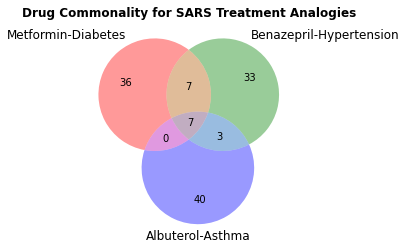

In [22]:
venn3([metf_diab_drug_set, benz_hypr_drug_set, albu_asth_drug_set],
      ('Metformin-Diabetes', 'Benazepril-Hypertension', 'Albuterol-Asthma'))
plt.title('Drug Commonality for SARS Treatment Analogies', fontdict={'fontweight':'bold'})
fig = plt.gcf()
plt.show()
fig.tight_layout()
fig.savefig('drugvenn.pdf')

In [23]:
# look at the exact intersect of all
full_intersect = metf_diab_drug_set & benz_hypr_drug_set & albu_asth_drug_set
print('Common to all: {0}'.format(len(full_intersect)))
print('\n'.join(sorted(full_intersect)))

Common to all: 7
amantadine hydrochloride
peramivir
revefenacin
rilpivirine hydrochloride
rimantadine hydrochloride
tamiflu
zanamivir


In [24]:
# and look at the 2-set common drugs
metf_benz = metf_diab_drug_set & benz_hypr_drug_set
benz_albu = benz_hypr_drug_set & albu_asth_drug_set
albu_metf = albu_asth_drug_set & metf_diab_drug_set
two_agree_intersect = (metf_benz | benz_albu | albu_metf) - full_intersect
print('Common to two: {0}'.format(len(two_agree_intersect)))
print('\n'.join(sorted(two_agree_intersect)))

Common to two: 10
alectinib hydrochloride
donepezil hydrochloride and memantine hydrochloride
doravirine
galantamine hydrobromide
gilteritinib fumarate
relenza
telavancin hydrochloride
triprolidine and pseudoephedrine hydrochlorides
triprolidine and pseudoephedrine hydrochlorides codeine
virazole


In [25]:
# print the common drugs for LaTeX
print(' \\\\ \n'.join(sorted(full_intersect)) + ' \\\\')
print('\\hline')
print(' \\\\ \n'.join(sorted(two_agree_intersect)) + ' \\\\')

amantadine hydrochloride \\ 
peramivir \\ 
revefenacin \\ 
rilpivirine hydrochloride \\ 
rimantadine hydrochloride \\ 
tamiflu \\ 
zanamivir \\
\hline
alectinib hydrochloride \\ 
donepezil hydrochloride and memantine hydrochloride \\ 
doravirine \\ 
galantamine hydrobromide \\ 
gilteritinib fumarate \\ 
relenza \\ 
telavancin hydrochloride \\ 
triprolidine and pseudoephedrine hydrochlorides \\ 
triprolidine and pseudoephedrine hydrochlorides codeine \\ 
virazole \\


# Further Validation
Are there other ways we can reassure ourselves that these treatment analogy vectors are useful?

### SARS Drugs without Treatment Analogy
What if we just look at the drugs close to the SARS vector?
Does the treatment analogy add anything or can we just look for nearby drugs?

In [26]:
sars_v = wv['sars'] / np.linalg.norm(wv['sars'])
# we'll just pretend that the straight SARS vector is the treat vector
sars_only_drugs_top50 = get_ranked_drugs_for_treat_vec(sars_v, drug_vec_tups, wv)[:50]
# just have a quick look at the hits and similarities
print('\n'.join([str(h) for h in sars_only_drugs_top50]))

('advil multi-symptom cold flu', 0.532331)
('skin exposure reduction paste against chemical warfare agents', 0.5225714)
('12 hour allergy and congestion', 0.5193556)
('peramivir', 0.51930225)
('capital and codeine', 0.51613104)
('24 hour allergy and congestion', 0.5138709)
('zanamivir', 0.50433624)
('and stavudine', 0.49758163)
('a', 0.4975437)
('air polymer-type a', 0.49691942)
('neomycin and polymyxin b sulfates and gramicidin', 0.49550873)
('tamiflu', 0.4939935)
('advil allergy and congestion relief', 0.4908529)
('capital soleil 15', 0.49071503)
('neomycin and polymyxin b sulfates and hydrocortisone', 0.48907417)
('neomycin and polymyxin b sulfates and dexamethasone', 0.4890272)
('relenza', 0.48679283)
('plan b', 0.48338327)
('abacavir and lamivudine', 0.47884923)
('plan b one-step', 0.4773303)
('abacavir sulfate and lamivudine', 0.47718054)
('imodium a-d', 0.47696587)
('advil dual action with acetaminophen', 0.47574458)
('victrelis', 0.47413698)
('pred mild', 0.47379205)
('lopinavi

### Check Top Hits for Major Diseases
Outside of repurposing drugs for a new disease, do the analogy vectors find reasonable drugs for major diseases with well known treatments?
Here we will filter to drugs for Alzheimer's, Allergies, and Cancer.
We chose these diseases or disease families because they broad and don't overlap much with the drug/disease analogies we have already chosen.
For example, finding useful drugs for allergies by using the metformin/diabetes analogy is reassuring because we don't expect a lot of overlap between allergies and diabetes.

### Alzheimer's

In [27]:
metf_diab_alzh_v = get_treatment_analogy_vector('metformin', 'diabetes', 'alzheimers', wv)
benz_hypr_alzh_v = get_treatment_analogy_vector('benazepril', 'hypertension', 'alzheimers', wv)
albu_asth_alzh_v = get_treatment_analogy_vector('albuterol', 'asthma', 'alzheimers', wv)
metf_diab_alzh_drugs = get_ranked_drugs_for_treat_vec(metf_diab_alzh_v, drug_vec_tups, wv)
benz_hypr_alzh_drugs = get_ranked_drugs_for_treat_vec(benz_hypr_alzh_v, drug_vec_tups, wv)
albu_asth_alzh_drugs = get_ranked_drugs_for_treat_vec(albu_asth_alzh_v, drug_vec_tups, wv)

In [28]:
print('\n'.join([str(h) for h in metf_diab_alzh_drugs[:10]]))

('rivastigmine', 0.648874)
('donepezil hydrochloride', 0.63082397)
('galantamine hydrobromide', 0.61604136)
('donepezil hydrochloride and memantine hydrochloride', 0.61301476)
('memantine hydrochloride', 0.6116571)
('selegiline', 0.6097966)
('rivastigmine tartrate', 0.59914774)
('rasagiline mesylate', 0.58862734)
('sulindac', 0.5881008)
('selegiline hydrochloride', 0.57982916)


In [29]:
print('\n'.join([str(h) for h in benz_hypr_alzh_drugs[:10]]))

('rivastigmine', 0.63541055)
('aricept', 0.6159019)
('rivastigmine tartrate', 0.58211374)
('donepezil hydrochloride', 0.5814178)
('selegiline', 0.57907933)
('entacapone', 0.57265466)
('galantamine hydrobromide', 0.56994504)
('aricept odt', 0.5424829)
('memantine hydrochloride', 0.5424706)
('rasagiline mesylate', 0.5417063)


In [30]:
print('\n'.join([str(h) for h in albu_asth_alzh_drugs[:10]]))

('galantamine hydrobromide', 0.5988689)
('rivastigmine', 0.5925529)
('donepezil hydrochloride', 0.5801568)
('rivastigmine tartrate', 0.5746311)
('memantine hydrochloride', 0.5645405)
('donepezil hydrochloride and memantine hydrochloride', 0.55707794)
('biperiden lactate', 0.5564456)
('exelon', 0.54072016)
('tacrine hydrochloride', 0.5357636)
('selegiline', 0.52703625)


In [31]:
# print them for a combined LaTeX table
print('\n'.join(['& {0} \\\\'.format(h[0]) for h in metf_diab_alzh_drugs[:10]]))
print('\n'.join(['& {0} \\\\'.format(h[0]) for h in benz_hypr_alzh_drugs[:10]]))
print('\n'.join(['& {0} \\\\'.format(h[0]) for h in albu_asth_alzh_drugs[:10]]))

& rivastigmine \\
& donepezil hydrochloride \\
& galantamine hydrobromide \\
& donepezil hydrochloride and memantine hydrochloride \\
& memantine hydrochloride \\
& selegiline \\
& rivastigmine tartrate \\
& rasagiline mesylate \\
& sulindac \\
& selegiline hydrochloride \\
& rivastigmine \\
& aricept \\
& rivastigmine tartrate \\
& donepezil hydrochloride \\
& selegiline \\
& entacapone \\
& galantamine hydrobromide \\
& aricept odt \\
& memantine hydrochloride \\
& rasagiline mesylate \\
& galantamine hydrobromide \\
& rivastigmine \\
& donepezil hydrochloride \\
& rivastigmine tartrate \\
& memantine hydrochloride \\
& donepezil hydrochloride and memantine hydrochloride \\
& biperiden lactate \\
& exelon \\
& tacrine hydrochloride \\
& selegiline \\


### Allergies

In [32]:
metf_diab_alrg_v = get_treatment_analogy_vector('metformin', 'diabetes', 'allergies', wv)
benz_hypr_alrg_v = get_treatment_analogy_vector('benazepril', 'hypertension', 'allergies', wv)
albu_asth_alrg_v = get_treatment_analogy_vector('albuterol', 'asthma', 'allergies', wv)
metf_diab_alrg_drugs = get_ranked_drugs_for_treat_vec(metf_diab_alrg_v, drug_vec_tups, wv)
benz_hypr_alrg_drugs = get_ranked_drugs_for_treat_vec(benz_hypr_alrg_v, drug_vec_tups, wv)
albu_asth_alrg_drugs = get_ranked_drugs_for_treat_vec(albu_asth_alrg_v, drug_vec_tups, wv)

In [33]:
print('\n'.join([str(h) for h in metf_diab_alrg_drugs[:10]]))

('cetirizine hydrochloride allergy', 0.73785204)
('fexofenadine hydrochloride allergy', 0.72374165)
('zyrtec allergy', 0.6787692)
('rhinocort allergy', 0.66665494)
('xyzal allergy 24hr', 0.6514833)
('azelastine hydrochloride and fluticasone propionate', 0.63693297)
('loratadine', 0.6367742)
('cetirizine hydrochloride hives', 0.63251704)
('ketotifen fumarate', 0.63016427)
('fexofenadine hydrochloride hives', 0.62369365)


In [34]:
print('\n'.join([str(h) for h in benz_hypr_alrg_drugs[:10]]))

('cetirizine hydrochloride allergy', 0.70203674)
('zyrtec allergy', 0.67894906)
('fexofenadine hydrochloride allergy', 0.6754744)
('rhinocort allergy', 0.6448313)
('cetirizine hydrochloride hives', 0.6433827)
('desloratadine', 0.6325138)
('loratadine', 0.6258365)
('fexofenadine hydrochloride hives', 0.62344646)
('acrivastine', 0.6047157)
('xyzal allergy 24hr', 0.6009445)


In [35]:
print('\n'.join([str(h) for h in albu_asth_alrg_drugs[:10]]))

('albuterol', 0.7314589)
('cetirizine hydrochloride allergy', 0.7255079)
('fexofenadine hydrochloride allergy', 0.72232145)
('albuterol sulfate', 0.70725495)
('levalbuterol hydrochloride', 0.6879714)
('albuterol sulfate and ipratropium bromide', 0.6749032)
('diphenhydramine citrate', 0.6620038)
('diphenhydramine hydrochloride preservative free', 0.6599874)
('levalbuterol tartrate', 0.65517354)
('triprolidine pseudoephedrine hydrochloride and codeine phosphate', 0.65107024)


In [36]:
# print them for a combined LaTeX table
print('\n'.join(['& {0} \\\\'.format(h[0]) for h in metf_diab_alrg_drugs[:10]]))
print('\n'.join(['& {0} \\\\'.format(h[0]) for h in benz_hypr_alrg_drugs[:10]]))
print('\n'.join(['& {0} \\\\'.format(h[0]) for h in albu_asth_alrg_drugs[:10]]))

& cetirizine hydrochloride allergy \\
& fexofenadine hydrochloride allergy \\
& zyrtec allergy \\
& rhinocort allergy \\
& xyzal allergy 24hr \\
& azelastine hydrochloride and fluticasone propionate \\
& loratadine \\
& cetirizine hydrochloride hives \\
& ketotifen fumarate \\
& fexofenadine hydrochloride hives \\
& cetirizine hydrochloride allergy \\
& zyrtec allergy \\
& fexofenadine hydrochloride allergy \\
& rhinocort allergy \\
& cetirizine hydrochloride hives \\
& desloratadine \\
& loratadine \\
& fexofenadine hydrochloride hives \\
& acrivastine \\
& xyzal allergy 24hr \\
& albuterol \\
& cetirizine hydrochloride allergy \\
& fexofenadine hydrochloride allergy \\
& albuterol sulfate \\
& levalbuterol hydrochloride \\
& albuterol sulfate and ipratropium bromide \\
& diphenhydramine citrate \\
& diphenhydramine hydrochloride preservative free \\
& levalbuterol tartrate \\
& triprolidine pseudoephedrine hydrochloride and codeine phosphate \\


### Cancer

In [37]:
metf_diab_cncr_v = get_treatment_analogy_vector('metformin', 'diabetes', 'cancer', wv)
benz_hypr_cncr_v = get_treatment_analogy_vector('benazepril', 'hypertension', 'cancer', wv)
albu_asth_cncr_v = get_treatment_analogy_vector('albuterol', 'asthma', 'cancer', wv)
metf_diab_cncr_drugs = get_ranked_drugs_for_treat_vec(metf_diab_cncr_v, drug_vec_tups, wv)
benz_hypr_cncr_drugs = get_ranked_drugs_for_treat_vec(benz_hypr_cncr_v, drug_vec_tups, wv)
albu_asth_cncr_drugs = get_ranked_drugs_for_treat_vec(albu_asth_cncr_v, drug_vec_tups, wv)

In [38]:
print('\n'.join([str(h) for h in metf_diab_cncr_drugs[:10]]))

('lapatinib', 0.6858946)
('cisplatin', 0.6831124)
('fulvestrant', 0.6756336)
('bicalutamide', 0.6745645)
('docetaxel', 0.66394734)
('gefitinib', 0.66016996)
('tamoxifen citrate', 0.6563145)
('gemcitabine', 0.64195096)
('erlotinib hydrochloride', 0.63755924)
('toremifene citrate', 0.632593)


In [39]:
print('\n'.join([str(h) for h in benz_hypr_cncr_drugs[:10]]))

('bicalutamide', 0.6260104)
('docetaxel', 0.6180023)
('cisplatin', 0.61061776)
('gemcitabine', 0.60835636)
('exemestane', 0.60618967)
('lapatinib', 0.60158914)
('fulvestrant', 0.598102)
('erlotinib hydrochloride', 0.5943975)
('gefitinib', 0.5941476)
('carboplatin', 0.5891766)


In [40]:
print('\n'.join([str(h) for h in albu_asth_cncr_drugs[:10]]))

('docetaxel', 0.6383779)
('toremifene citrate', 0.6259003)
('tamoxifen citrate', 0.6234828)
('erlotinib hydrochloride', 0.62265384)
('gemcitabine hydrochloride', 0.62196404)
('cisplatin', 0.61619025)
('bicalutamide', 0.6119899)
('doxorubicin hydrochloride', 0.60101885)
('gemcitabine', 0.5993188)
('epirubicin hydrochloride', 0.59865206)


In [41]:
# print them for a combined LaTeX table
print('\n'.join(['& {0} \\\\'.format(h[0]) for h in metf_diab_cncr_drugs[:10]]))
print('\n'.join(['& {0} \\\\'.format(h[0]) for h in benz_hypr_cncr_drugs[:10]]))
print('\n'.join(['& {0} \\\\'.format(h[0]) for h in albu_asth_cncr_drugs[:10]]))

& lapatinib \\
& cisplatin \\
& fulvestrant \\
& bicalutamide \\
& docetaxel \\
& gefitinib \\
& tamoxifen citrate \\
& gemcitabine \\
& erlotinib hydrochloride \\
& toremifene citrate \\
& bicalutamide \\
& docetaxel \\
& cisplatin \\
& gemcitabine \\
& exemestane \\
& lapatinib \\
& fulvestrant \\
& erlotinib hydrochloride \\
& gefitinib \\
& carboplatin \\
& docetaxel \\
& toremifene citrate \\
& tamoxifen citrate \\
& erlotinib hydrochloride \\
& gemcitabine hydrochloride \\
& cisplatin \\
& bicalutamide \\
& doxorubicin hydrochloride \\
& gemcitabine \\
& epirubicin hydrochloride \\
